In [1]:
using QuadGK,LaTeXStrings,LinearAlgebra,BenchmarkTools;
using Plots;
import Optim,NLsolve;
pyplot(frame=:box, minorticks=5, size=(500,350), fontfamily="serif",titlefontsize=11
    ,guidefontsize=12,tickfontsize=11,legendfontsize=9,
    bg_color_legend = RGBA(1,1,1,0.15), markerstrokecolor= :auto);

In [2]:
include("./libs/constants.jl");
include("./libs/pwa.jl");
include("./libs/potentials.jl");

In [3]:
λf(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z
q0f(E, m1, m2, m3, m4) = abs(m3^2 - m4^2 - m1^2 + m2^2) / (2 * E)
μf(m1, m2) = m1 * m2 / (m1 + m2)

# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >=0 ? sqrt(x+0im) : -sqrt(x-0im)
end

xsqrt (generic function with 1 method)

In [4]:
xxx,www=gauss(96,0,1);

In [5]:
qi=zeros(ComplexF64,length(xxx)+1);
wi=zeros(ComplexF64,length(xxx));
len=length(xxx);
sublen=length(qi);

In [6]:
Vmat=zeros(ComplexF64,sublen,sublen);
Gmat=zeros(ComplexF64,sublen,sublen);
Tmat=zeros(ComplexF64,sublen,sublen);

# DD

In [7]:
function detVG(E,Λ;I=0,rs=1,qi=qi,wi=wi,vv=Vmat,gg=Gmat)
    mμ=μf(mDn,mDc)
    qi[1]=xsqrt(2*mμ*(E-mDn-mDc))*(-1)^(rs+1)
    for i in eachindex(xxx)
        qi[i+1]=Λ*xxx[i]
        wi[i]=Λ*www[i]
    end
    
    # assigning V matrix
    for i in eachindex(qi)
        for j in eachindex(qi)
            vv[i,j]=potential_DDc(E,qi[i],qi[j];I=I)
        end
    end
    
    kon=qi[1]
    # assigning G matrix
    tmp=zero(ComplexF64)
    for i in eachindex(wi)
        gg[i+1,i+1]=wi[i]*qi[1+i]^2/(2π^2)/(E-mDn-mDc-qi[1+i]^2/(2*mμ))
        tmp+=-wi[i]*kon^2/(2π^2)/(E-mDn-mDc-qi[1+i]^2/(2*mμ))
    end
    gg[1,1]=tmp+mμ*kon/(2π^2)*(log((Λ+kon)/(Λ-kon))-im*π)
    
    return det(LinearAlgebra.I-vv*gg)
end

detVG (generic function with 1 method)

In [8]:
function Tmat!(E,Λ;I=0,rs=1,qi=qi,wi=wi,vv=Vmat,gg=Gmat,tt=Tmat)
    mμ=μf(mDn,mDc)
    qi[1]=xsqrt(2*mμ*(E-mDn-mDc))*(-1)^(rs+1)
    for i in eachindex(xxx)
        qi[i+1]=Λ*xxx[i]
        wi[i]=Λ*www[i]
    end
    
    # assigning V matrix
    for i in eachindex(qi)
        for j in eachindex(qi)
            vv[i,j]=potential_DDc(E,qi[i],qi[j];I=I)
        end
    end
    
    kon=qi[1]
    # assigning G matrix
    tmp=zero(ComplexF64)
    for i in eachindex(wi)
        gg[i+1,i+1]=wi[i]*qi[1+i]^2/(2π^2)/(E-mDn-mDc-qi[1+i]^2/(2*mμ))
        tmp+=-wi[i]*kon^2/(2π^2)/(E-mDn-mDc-qi[1+i]^2/(2*mμ))
    end
    gg[1,1]=tmp+mμ*kon/(2π^2)*(log((Λ+kon)/(Λ-kon))-im*π)
    
    tt .=inv(LinearAlgebra.I-vv*gg)*vv
    nothing
end

Tmat! (generic function with 1 method)

In [9]:
function find_poles(pars)
    _lam,_rs,_I=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ, _lam;I=_I,rs=_rs)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDc, 0.0])
end

find_poles (generic function with 1 method)

In [10]:
find_poles([0.75,1,0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [3.73445, 0.0]
 * Zero: [3.734047801228666, -3.3286788781876217e-15]
 * Inf-norm of residuals: 0.000000
 * Iterations: 5
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 6
 * Jacobian Calls (df/dx): 6

In [11]:
3.734047801228666-mDn-mDc

-0.00040219877133407245

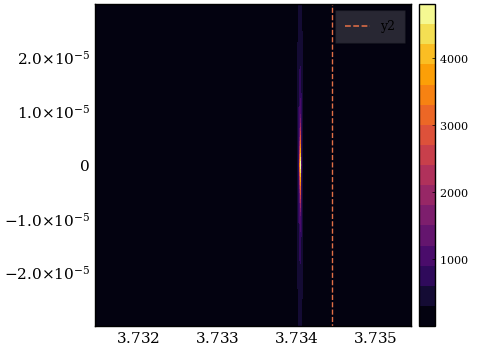

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [12]:
let Ev=collect(mDn+mDc-0.003:10e-6:mDn+mDc+0.001),Γv=collect(-30e-6:10e-6:30e-6)
    resv=[1/abs(detVG(e+im*γ,0.75;I=0,rs=1)) for γ in Γv,e in Ev]
    contour(Ev,Γv,resv,fill=true)
    vline!([mDn+mDc],ls=:dash)
end

In [13]:
function find_poles_selected(pars)
    _lam,_rs,_I=pars
    function f!(F, x)
        e, γ = x
        tmp = detVG(e + im * γ, _lam;I=_I,rs=_rs)
        F[1] = real(tmp)
        F[2] = imag(tmp)
    end
    tmp=NLsolve.nlsolve((F, x) -> f!(F, x), [mDn + mDc, 0.0])
    return tmp.residual_norm < 1e-8 ? tmp.zero[1]+im*tmp.zero[2] : NaN+im*NaN
end

find_poles_selected (generic function with 1 method)

In [14]:
find_poles_selected([0.75,1,0])

3.734047801228666 - 3.3286788781876217e-15im

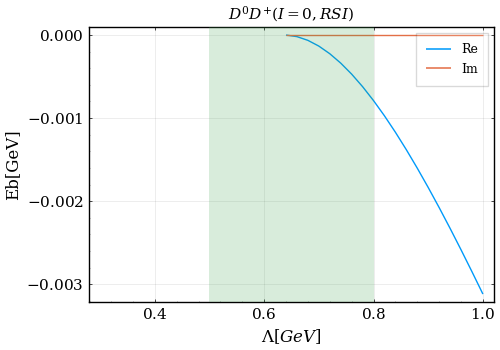

In [15]:
let Λv=collect(0.3:0.02:1.0)
    resv=[find_poles_selected([Λ,1,0])-mDn-mDc for Λ in Λv]
    plot(Λv,real.(resv),label="Re",title=L"D^0D^{+}(I=0,RSI)",xlabel=L"\Lambda[GeV]",ylabel="Eb[GeV]")
    plot!(Λv,imag.(resv),label="Im")
    plot!([0.5,0.8],seriestype=:vspan,seriesalpha=0.2,label=false)
end

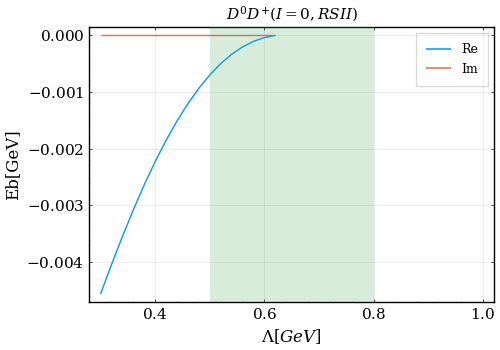

In [16]:
let Λv=collect(0.3:0.02:1.0)
    resv=[find_poles_selected([Λ,2,0])-mDn-mDc for Λ in Λv]
    plot(Λv,real.(resv),label="Re",title=L"D^0D^{+}(I=0,RSII)",xlabel=L"\Lambda[GeV]",ylabel="Eb[GeV]")
    plot!(Λv,imag.(resv),label="Im")
    plot!([0.5,0.8],seriestype=:vspan,seriesalpha=0.2,label=false)
end

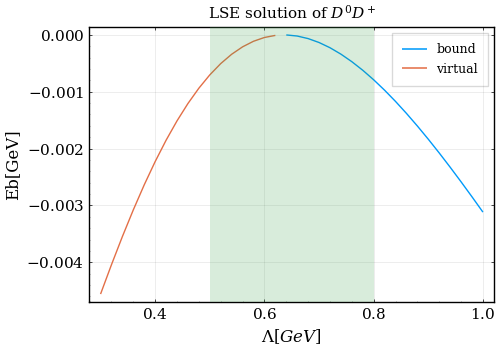

In [17]:
let Λv=collect(0.3:0.02:1.0)
    resv_1=[find_poles_selected([Λ,1,0])-mDn-mDc for Λ in Λv]
    resv_2=[find_poles_selected([Λ,2,0])-mDn-mDc for Λ in Λv]
    plot(Λv,real.(resv_1),label="bound",title=L"LSE solution of $D^0D^+$",xlabel=L"\Lambda[GeV]",ylabel="Eb[GeV]")
    plot!(Λv,real.(resv_2),label="virtual")
    plot!([0.5,0.8],seriestype=:vspan,seriesalpha=0.2,label=false)
end

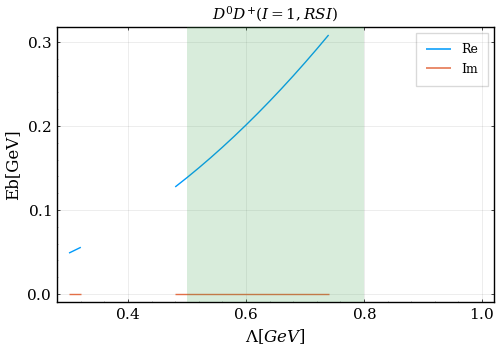

In [18]:
let Λv=collect(0.3:0.02:1.0)
    resv=[find_poles_selected([Λ,1,1])-mDn-mDc for Λ in Λv]
    plot(Λv,real.(resv),label="Re",title=L"D^0D^{+}(I=1,RSI)",xlabel=L"\Lambda[GeV]",ylabel="Eb[GeV]")
    plot!(Λv,imag.(resv),label="Im")
    plot!([0.5,0.8],seriestype=:vspan,seriesalpha=0.2,label=false)
end

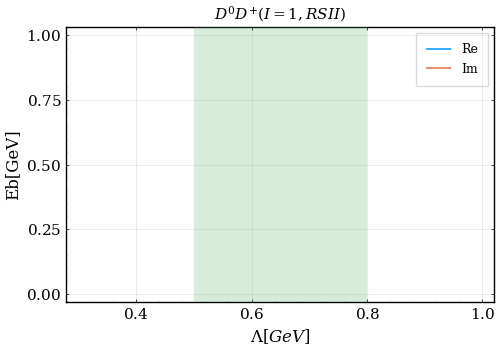

In [19]:
let Λv=collect(0.3:0.02:1.0)
    resv=[find_poles_selected([Λ,2,1])-mDn-mDc for Λ in Λv]
    plot(Λv,real.(resv),label="Re",title=L"D^0D^{+}(I=1,RSII)",xlabel=L"\Lambda[GeV]",ylabel="Eb[GeV]")
    plot!(Λv,imag.(resv),label="Im")
    plot!([0.5,0.8],seriestype=:vspan,seriesalpha=0.2,label=false)
end